In [51]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import optim
import pickle
import torchvision
import os
import time
from data_collector import DataCollector
from models import Discriminator, Generator, GAN
import shutil


%matplotlib inline

In [52]:
def get_dataloader(dataset_path, image_size, batch_size):
  transforms = tt.Compose([tt.Resize((image_size, image_size)),
                           tt.ToTensor(),
                           tt.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
  folder = ImageFolder(dataset_path, transform=transforms)
  return DataLoader(folder, batch_size, drop_last=True, shuffle=True)

In [53]:
dataset_path = "/Users/osiprovin/Desktop/work/ML:DL/GANS/CDGAN/Images"
image_size = 64
batch_size = 128

dataloader = get_dataloader(dataset_path, image_size, batch_size)

In [54]:
img = tt.ToPILImage(next(iter(dataloader))[0][0])

----

In [55]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [56]:
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
latent_size = 128

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Learning rate for optimizers
lr = 0.0001

device = torch.device(torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu'))

In [57]:
def show_generated_images(images):
    images = images / 2 + 0.5  # Denormalize
    grid = np.transpose(torchvision.utils.make_grid(images, nrow=5, padding=2, normalize=True), (1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()


----

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


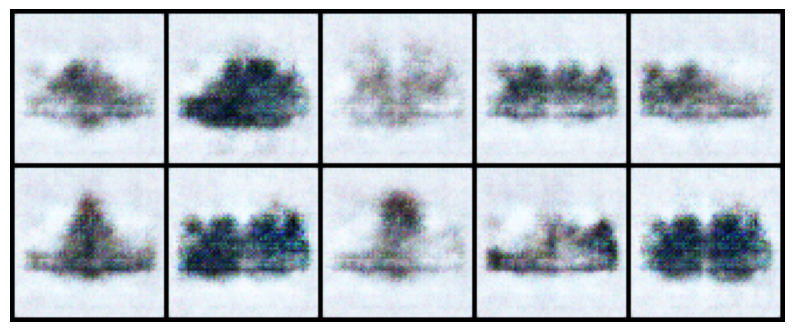

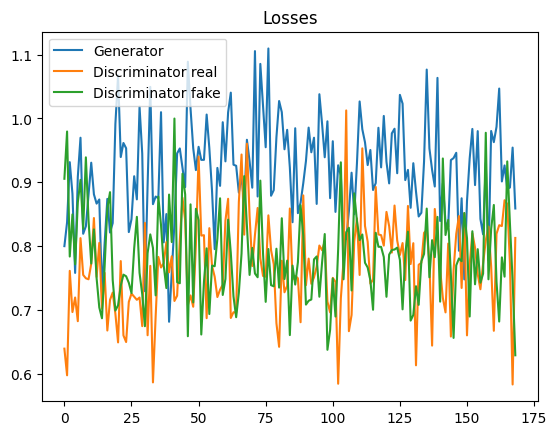

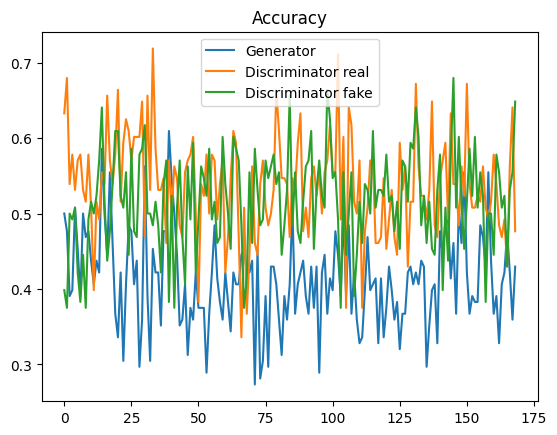

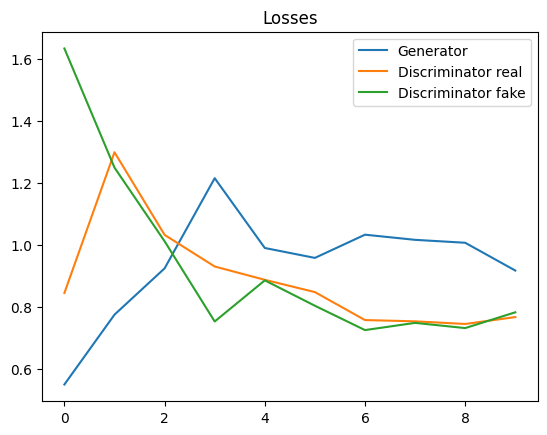

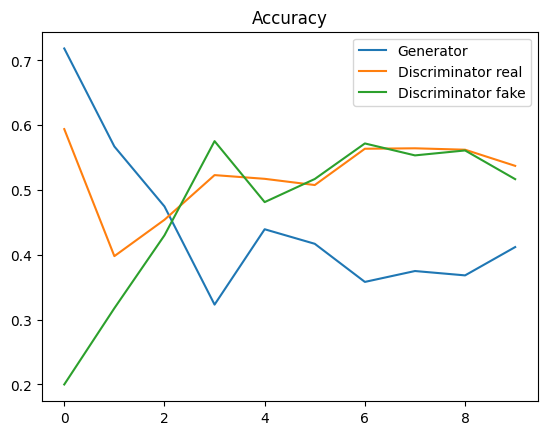

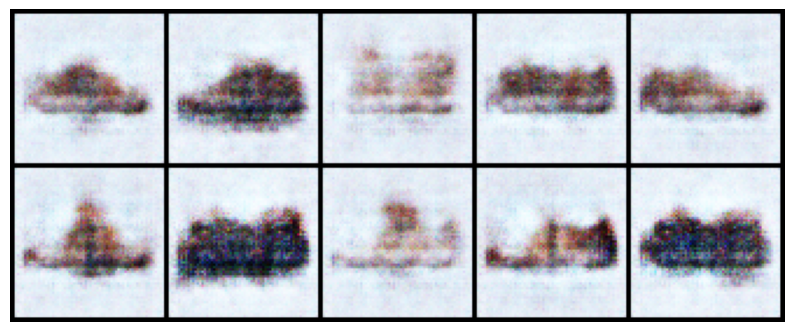

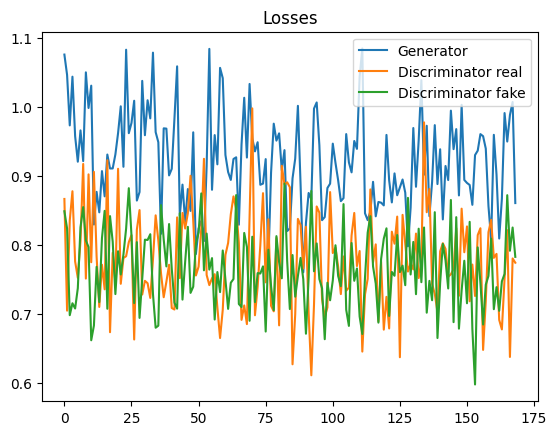

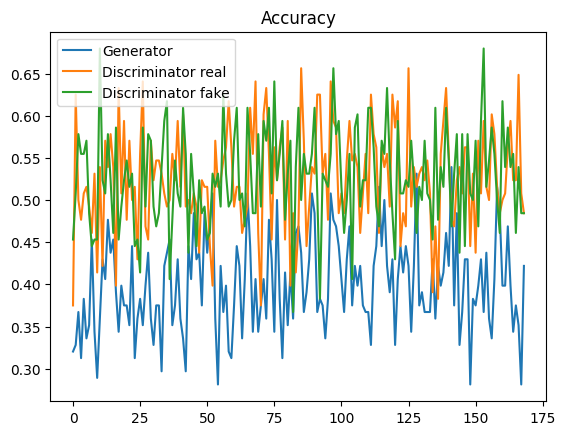

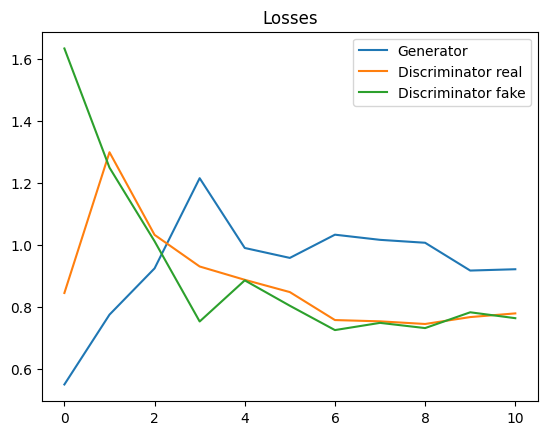

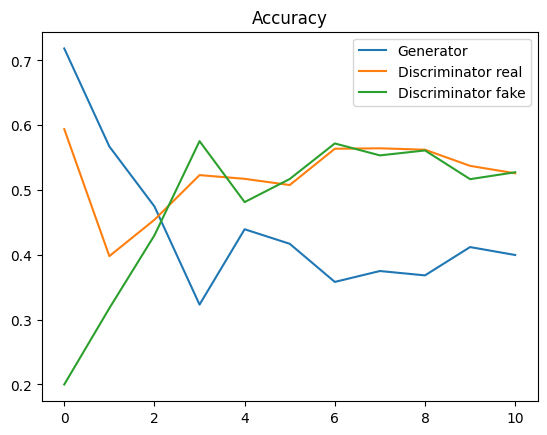

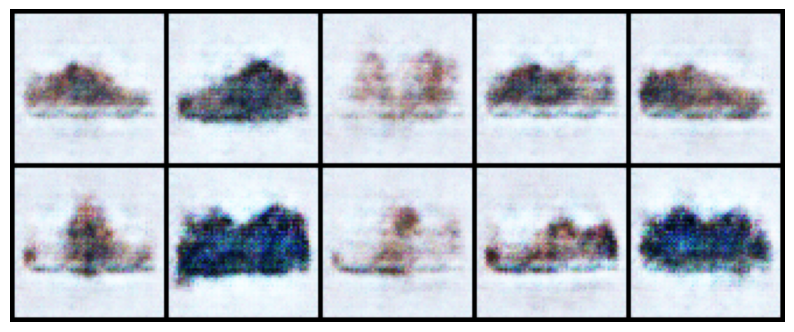

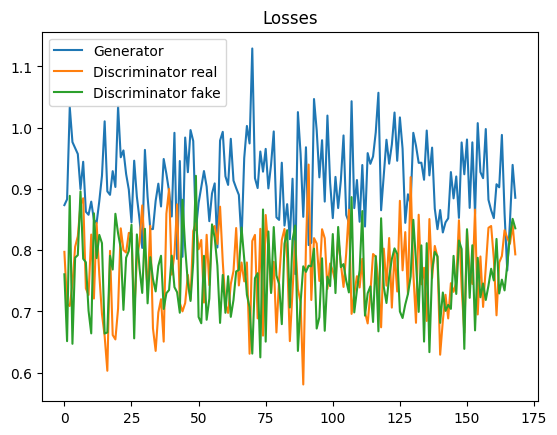

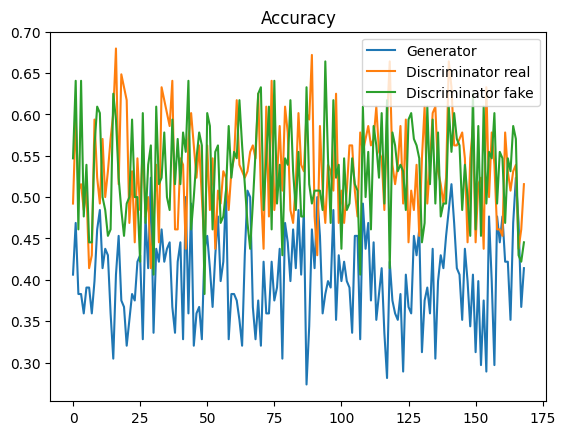

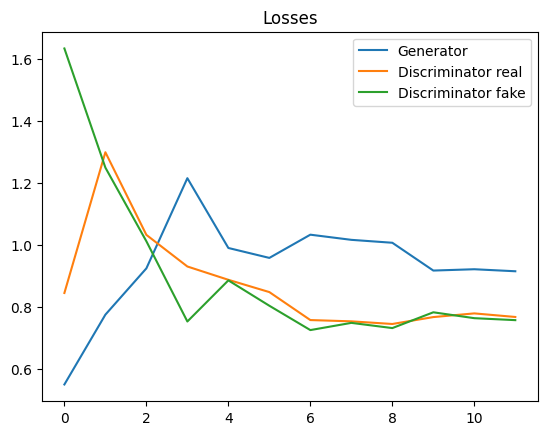

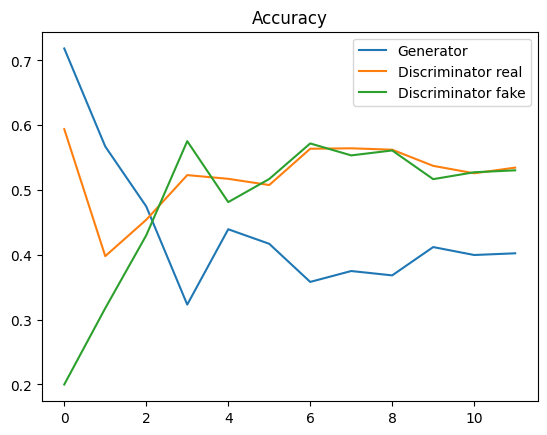

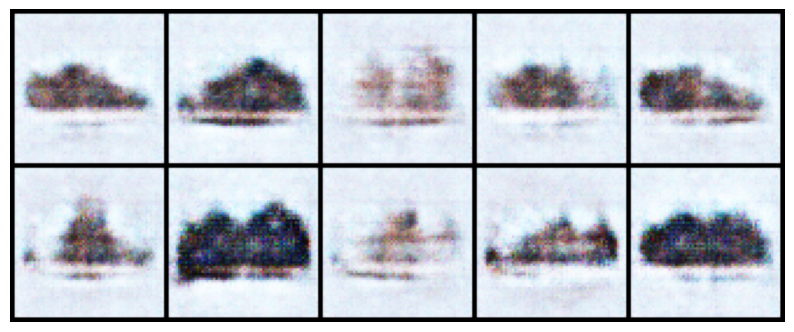

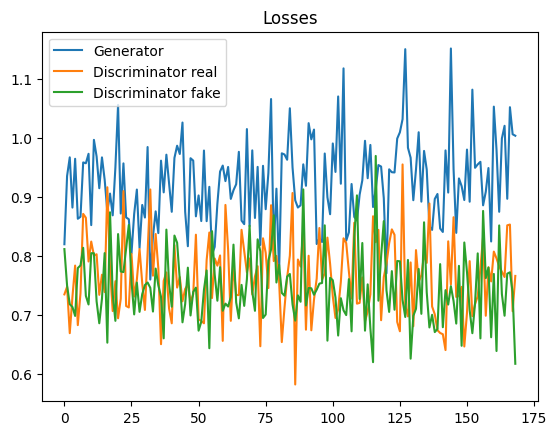

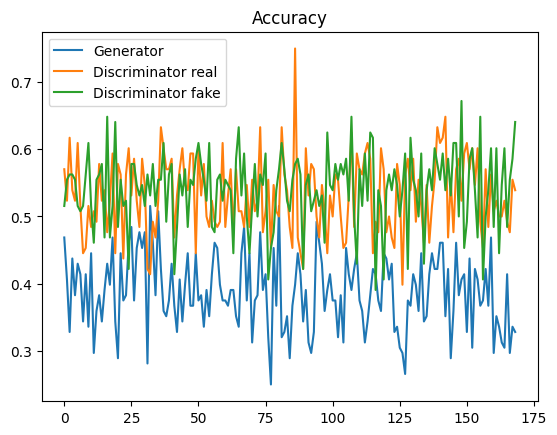

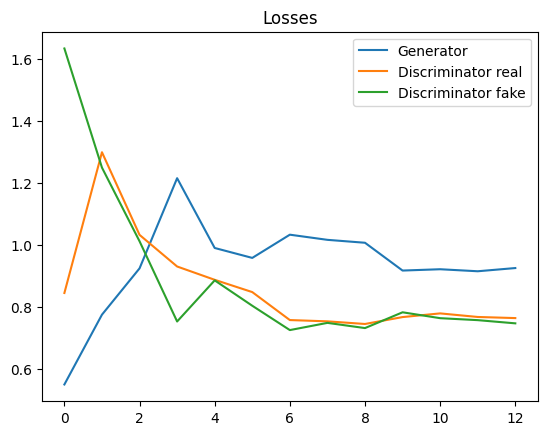

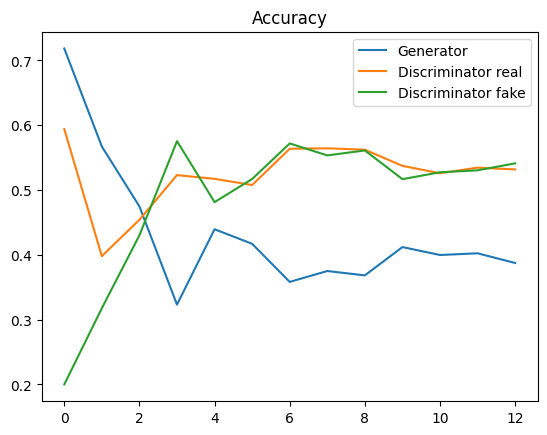

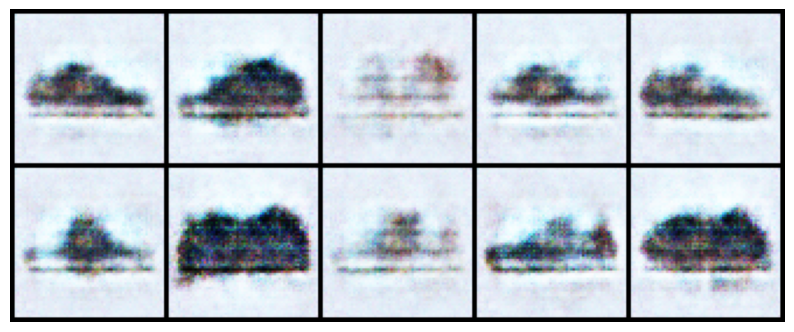

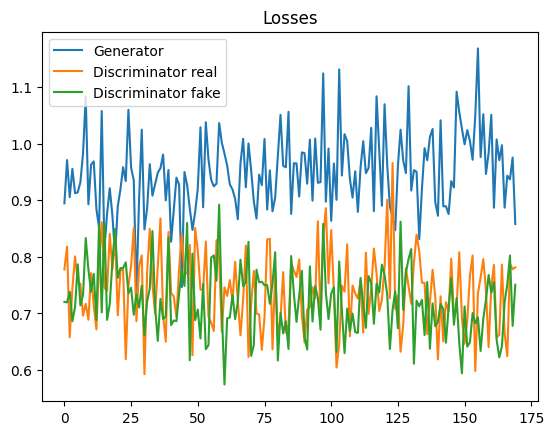

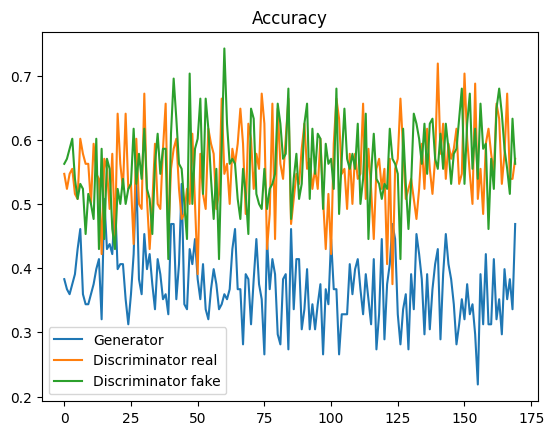

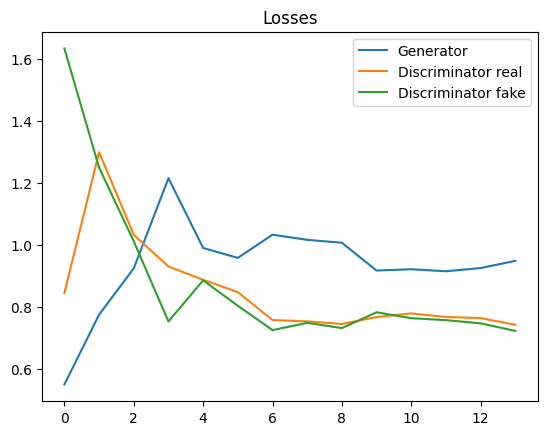

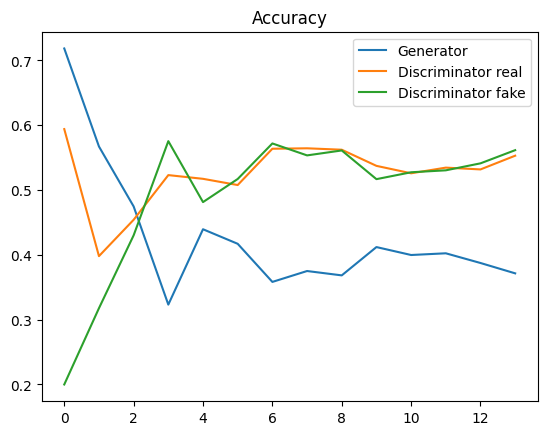

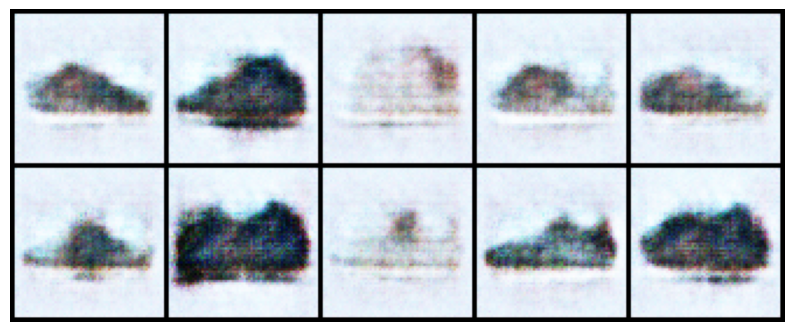

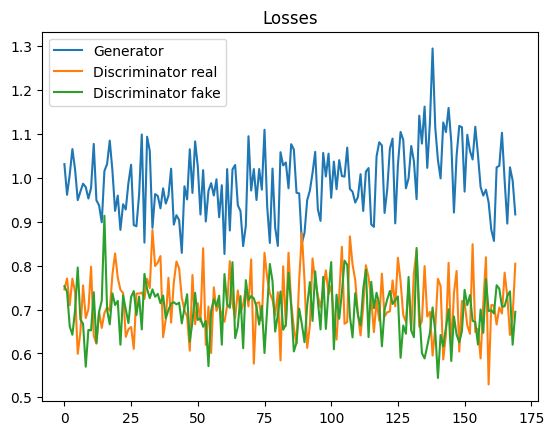

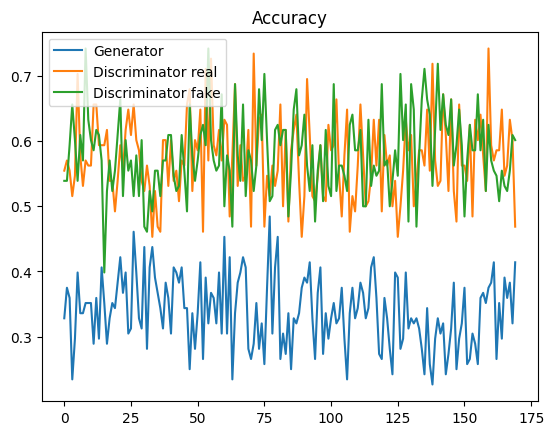

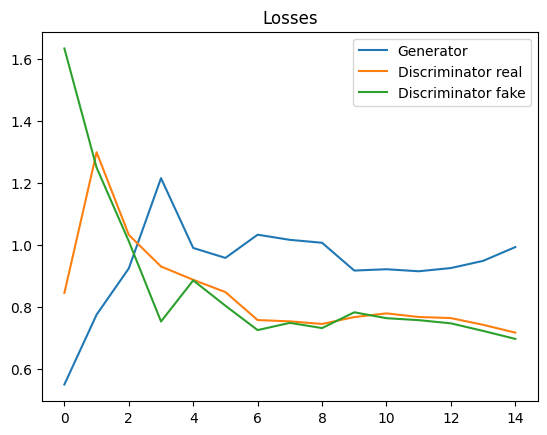

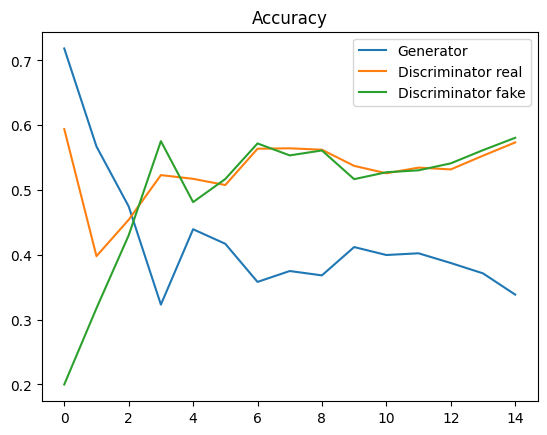

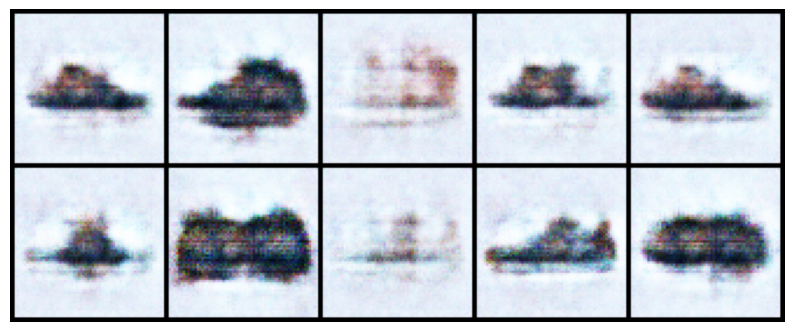

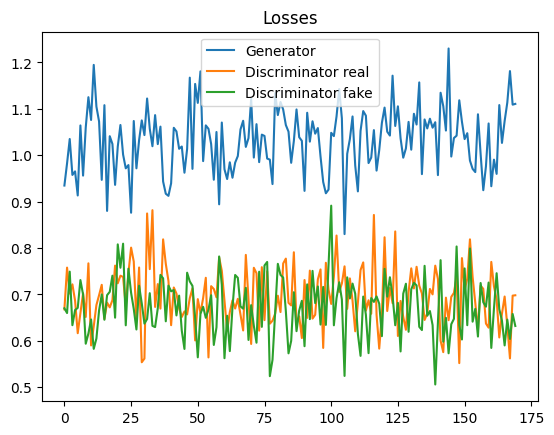

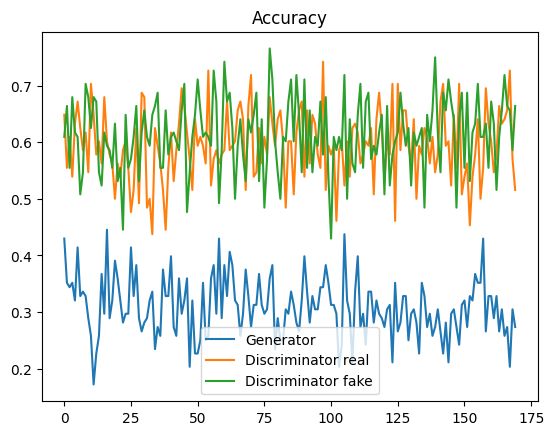

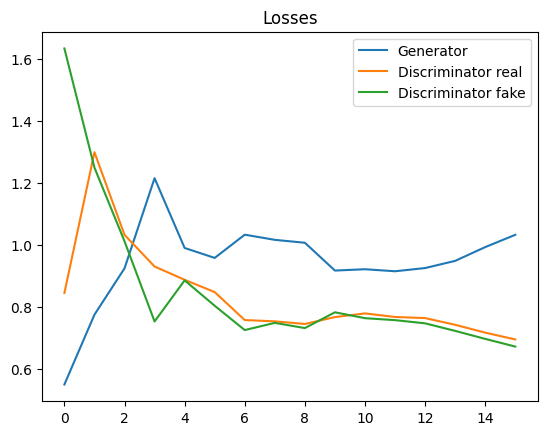

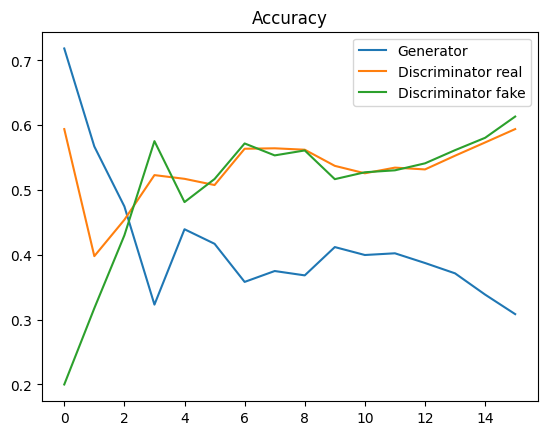

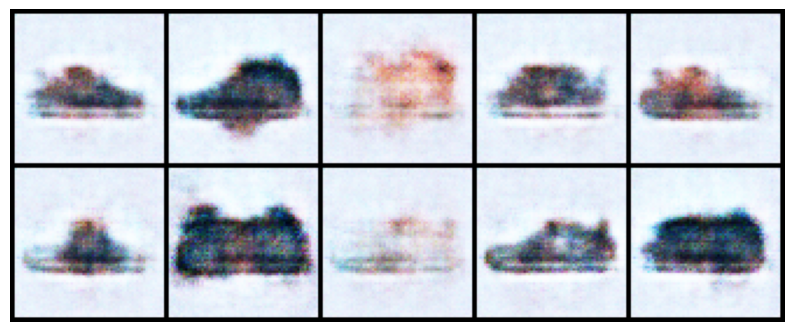

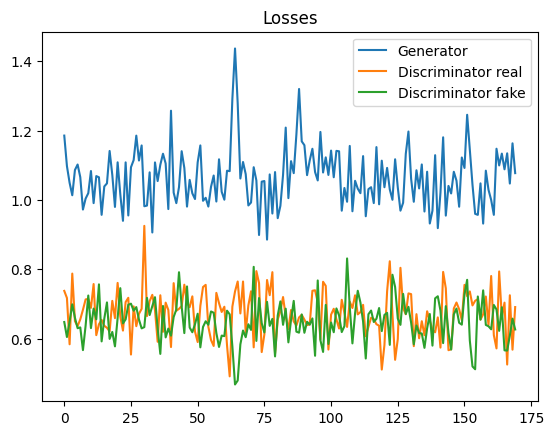

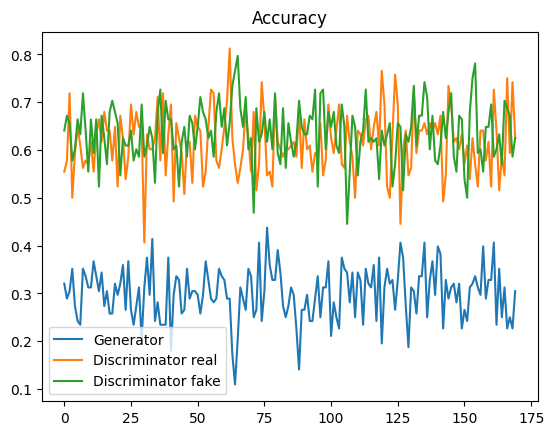

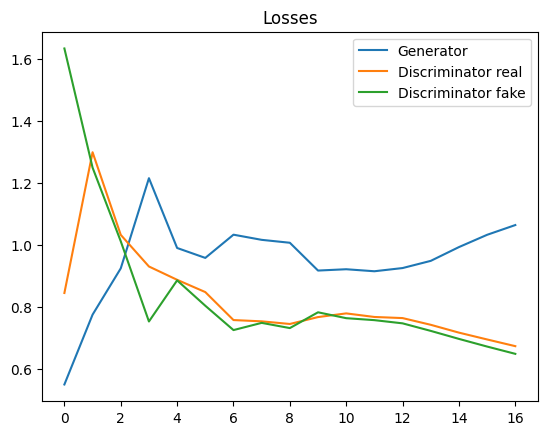

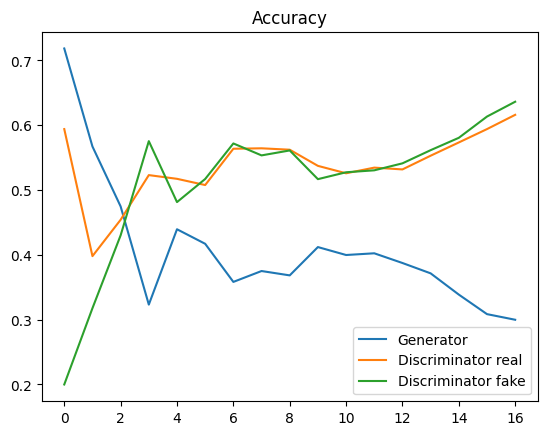

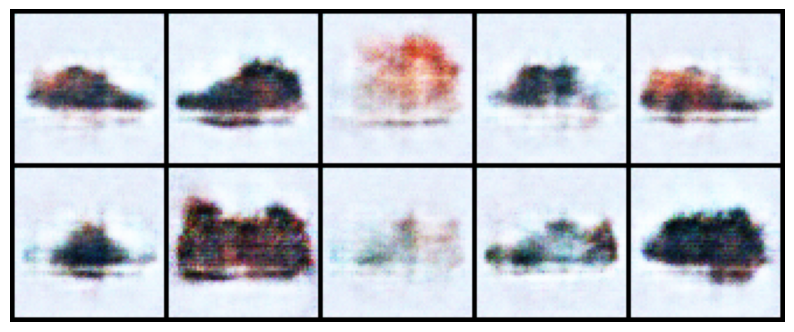

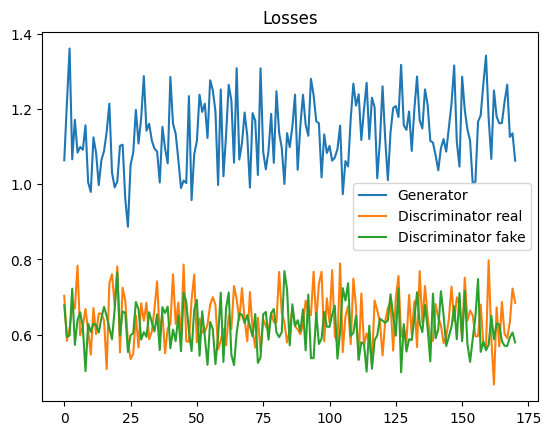

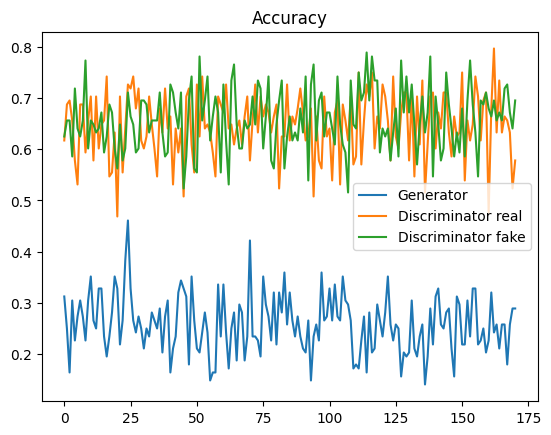

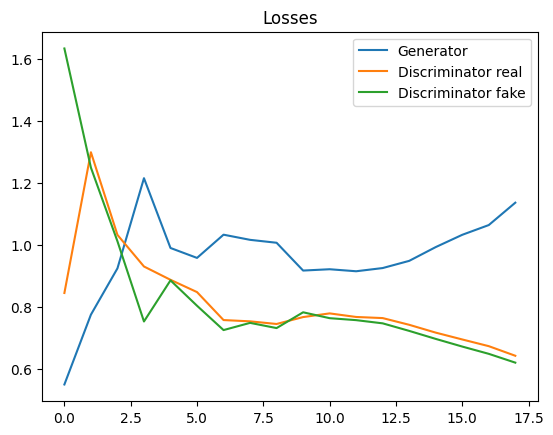

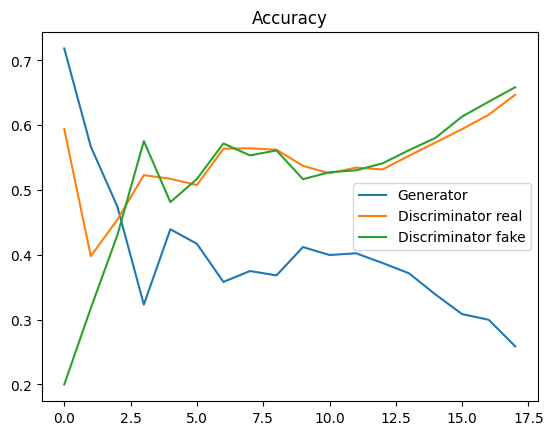

In [58]:
INIT = False

discriminator = Discriminator(nc, ndf)
generator = Generator(latent_size, ngf, nc, device)

if INIT:
    discriminator.apply(weights_init)
    generator.apply(weights_init)

    folder_path = "/Users/osiprovin/Desktop/work/ML:DL/GANS/CDGAN/imgs"
    shutil.rmtree(folder_path)
    os.makedirs(folder_path)  
else:
    generator_path = '/Users/osiprovin/Desktop/work/ML:DL/GANS/CDGAN/STATE_DICTS/generator_weights.pth'
    generator.load_state_dict(torch.load(generator_path))
    discriminator_path = '/Users/osiprovin/Desktop/work/ML:DL/GANS/CDGAN/STATE_DICTS/discriminator_weights.pth'
    discriminator.load_state_dict(torch.load(discriminator_path))

data_collector = DataCollector(INIT=INIT, root="/Users/osiprovin/Desktop/work/ML:DL/GANS/CDGAN/LOSS_ACCURACY")
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")


gan = GAN(generator=generator,
          discriminator=discriminator,
          device=device,
          latent_size=latent_size,
          batch_size=batch_size,
          lr_discriminator=lr/8,
          lr_generator=lr)

generator_accuracy = 0
discriminator_accuracy_real = 0
discriminator_accuracy_fake = 0

loader = iter(dataloader)

start_time = time.time()

TRAIN_MINUTES = 30
EPOCH_MINUTES = 3

epoch_time = time.time()
epoch_data_collector = DataCollector(INIT=True, root="/Users/osiprovin/Desktop/work/ML:DL/GANS/CDGAN/LOSS_ACCURACY")

while (time.time() - start_time) // 60 < TRAIN_MINUTES:

    # discriminator train on real data 
    if discriminator_accuracy_real < 0.8:
        try:
            images = next(loader)[0].to(device)
        except StopIteration:
            loader = iter(dataloader)

        discriminator_error_real, discriminator_accuracy_real = gan.train_step(images, "discriminator", "real")              
    else:

        try:
            images = next(loader)[0].to(device)
        except StopIteration:
            loader = iter(dataloader)

        with torch.no_grad():
            discriminator_error_real, discriminator_accuracy_real = gan.get_error_accuracy(images, "real")


    # discriminator train on fake data
    if discriminator_accuracy_fake < 0.8:
        fake_images = gan.generate()
        discriminator_error_fake, discriminator_accuracy_fake = gan.train_step(fake_images, "discriminator", "fake")              
    else:
        with torch.no_grad():
            fake_images = gan.generate()
            discriminator_error_fake, discriminator_accuracy_fake = gan.get_error_accuracy(fake_images, "fake")


    # generator train
    if generator_accuracy < 0.9:
        fake_images = gan.generate()
        generator_error, generator_accuracy = gan.train_step(fake_images, "generator", "real")                
    else:
        with torch.no_grad():
            fake_images = gan.generate()
            generator_error, generator_accuracy = gan.get_error_accuracy(fake_images, "real")




    with torch.no_grad():
        epoch_data_collector.G_losses.append(generator_error.item())
        epoch_data_collector.G_accuracy.append(generator_accuracy.item())

        epoch_data_collector.D_real_losses.append(discriminator_error_real.item())
        epoch_data_collector.D_real_accuracy.append(discriminator_accuracy_real.item())

        epoch_data_collector.D_fake_losses.append(discriminator_error_fake.item())
        epoch_data_collector.D_fake_accuracy.append(discriminator_accuracy_fake.item())
    

    if (time.time() - epoch_time) // 60 >= EPOCH_MINUTES:
        epoch_time = time.time()

        # show generated images and plot accuracy and error
        with torch.no_grad():
            fake = gan.generate(fix=True)
            tt.ToPILImage()(fake[2]).save(f"/Users/osiprovin/Desktop/work/ML:DL/GANS/CDGAN/imgs/{epoch_time}.png")
            show_generated_images(fake.cpu())

            epoch_data_collector.plot([epoch_data_collector.G_losses, epoch_data_collector.D_real_losses, epoch_data_collector.D_fake_losses], ["Generator", "Discriminator real", "Discriminator fake"], "Losses")
            epoch_data_collector.plot([epoch_data_collector.G_accuracy, epoch_data_collector.D_real_accuracy, epoch_data_collector.D_fake_accuracy], ["Generator", "Discriminator real", "Discriminator fake"], "Accuracy")

            data_collector.G_losses.append(sum(epoch_data_collector.G_losses) / len(epoch_data_collector.G_losses))
            data_collector.G_accuracy.append(sum(epoch_data_collector.G_accuracy) / len(epoch_data_collector.G_accuracy))

            data_collector.D_real_losses.append(sum(epoch_data_collector.D_real_losses) / len(epoch_data_collector.D_real_losses))
            data_collector.D_real_accuracy.append(sum(epoch_data_collector.D_real_accuracy) / len(epoch_data_collector.D_real_accuracy))

            data_collector.D_fake_losses.append(sum(epoch_data_collector.D_fake_losses) / len(epoch_data_collector.D_fake_losses))
            data_collector.D_fake_accuracy.append(sum(epoch_data_collector.D_fake_accuracy) / len(epoch_data_collector.D_fake_accuracy))

            data_collector.plot([data_collector.G_losses, data_collector.D_real_losses, data_collector.D_fake_losses], ["Generator", "Discriminator real", "Discriminator fake"], "Losses")
            data_collector.plot([data_collector.G_accuracy, data_collector.D_real_accuracy, data_collector.D_fake_accuracy], ["Generator", "Discriminator real", "Discriminator fake"], "Accuracy")

            epoch_data_collector = DataCollector(INIT=True, root="/Users/osiprovin/Desktop/work/ML:DL/GANS/CDGAN/LOSS_ACCURACY")


# save models and collected data
# torch.save(gan.models["generator"].state_dict(), '/Users/osiprovin/Desktop/ml:dl/GANS/CDGAN/STATE_DICTS/generator_weights.pth')
# torch.save(gan.models["discriminator"].state_dict(), '/Users/osiprovin/Desktop/ml:dl/GANS/CDGAN/STATE_DICTS/discriminator_weights.pth')
# data_collector.save()

In [59]:
torch.save(gan.models["generator"].state_dict(), '/Users/osiprovin/Desktop/work/ML:DL/GANS/CDGAN/STATE_DICTS/generator_weights.pth')
torch.save(gan.models["discriminator"].state_dict(), '/Users/osiprovin/Desktop/work/ML:DL/GANS/CDGAN/STATE_DICTS/discriminator_weights.pth')
data_collector.save()

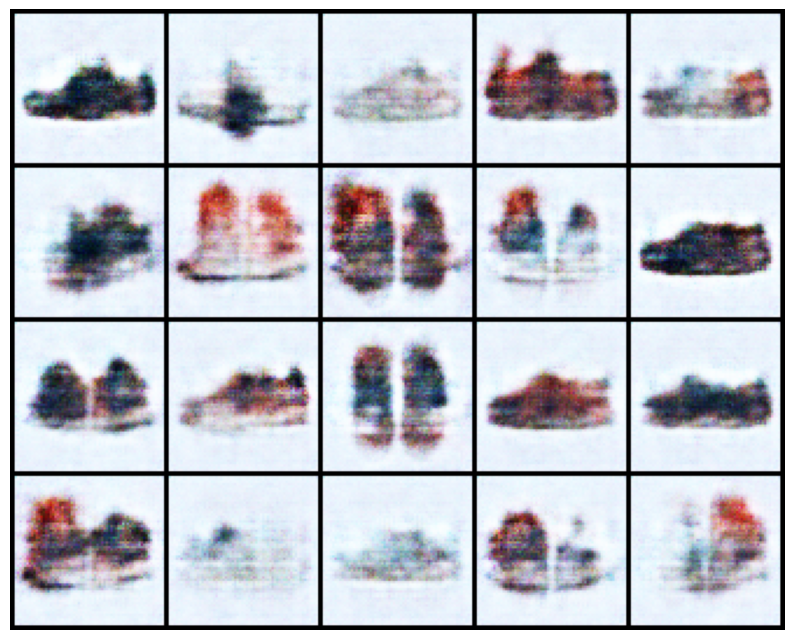

In [60]:
generator = Generator(latent_size, ngf, nc, device).to(device)
generator_path = '/Users/osiprovin/Desktop/work/ML:DL/GANS/CDGAN/STATE_DICTS/generator_weights.pth'
generator.load_state_dict(torch.load(generator_path))
noise = torch.randn(20, latent_size, 1, 1, device=device)
gen = generator(noise.to(device)).cpu()
show_generated_images(gen)